# Ca-dependent short-term synaptic plasticity

Presynaptic release 
\begin{eqnarray}
\partial_t c &=& \frac{c_m - c}{\tau_c}  - \phi(t)
\\
\partial_t p &=& \frac{p_{\infty}(c) - p}{\tau_p}
\\
\partial_t q &=& q \left( \frac{q_{\infty} - q}{\tau_q} \right) (1- p)
\end{eqnarray}

Stimulation functions
\begin{eqnarray}
\phi(t) &=& \sum_{i} \alpha(t-t_i; \tau)
\\
\alpha(s) &=& H(s)\frac{s}{\tau} \exp\left( 1-\frac{s}{\tau}\right), 
\end{eqnarray}
with $H(s)= 1$ if $s\geq 0$ and $0$ if $s<0$.


In [11]:
import scipy as sc
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import matplotlib.pylab as gr
%matplotlib inline

## Stimulation functions

In [12]:
def alphaFunction(x, A=1.0, tau=1.0, downAccel=1.0):
    """
    alphaFunction creates an alpha function with amplitude A, time constant tau, 
    and downward acceleration downAccel.  
    Example:
    alphaFunction(x, A=1.0, tau=1.0, downAccel=1.0)
    """
    aa= sc.int32(x>0)
    xovertau = x/tau
    return A* aa* xovertau * sc.exp( downAccel*(1 - xovertau))

def trainAlpha(samplingTimes, pulseTimes, stimAmp=1.0, tauTrain=1.0,downAccel=1.0):
    """
    Example:
    a= trainAlpha(samplingTimes, pulseTimes, tauTrain=1.0,downAccel=1.0)
    """
    nPts= len(samplingTimes)
    train = sc.zeros(nPts)
    alpha=alphaFunction(samplingTimes,A=stimAmp,tau=tauTrain,downAccel=downAccel)
    for n in range(len(pulseTimes)):
        #nn=gr.find(samplingTimes<pulseTimes[n]).max()
        nn=sc.where(samplingTimes<pulseTimes[n])[0].max()
        train[nn:] = train[nn:] + alpha[0: nPts-nn]
    return train

Parameters

In [14]:
p={"tau_pR": 1.0, "tau_q": 30.0, "tau_c":50.0, "tau_syn":10.0,
   "g_pR": 1.0/100.0, "q_ss":0.9, "c_ss": 1e-3, "stim_Amp": 0.005,
   "c_p":0.5}
p["stimStart"]=60.0; p["stimEnd"]=500.0; p["stimInterval"]=50.0;
p["timeMax"]=600.0; p["timeStep"]=1e-2
sampTimes=sc.arange(0,p["timeMax"],p["timeStep"])
p["sampTimes"] = sampTimes
p["stimTimes"] = sc.arange(p["stimStart"], p["stimEnd"], p["stimInterval"])
p["stimTrain"] = trainAlpha(samplingTimes=p["sampTimes"], pulseTimes=p["stimTimes"], stimAmp=p["stim_Amp"], tauTrain=p["tau_syn"])

In [15]:
p["pR_ss"]= lambda c : 1/(1+ sc.exp((p["c_p"]-c)/p["g_pR"]))
p["phi"]= interp1d(p["sampTimes"], p["stimTrain"])

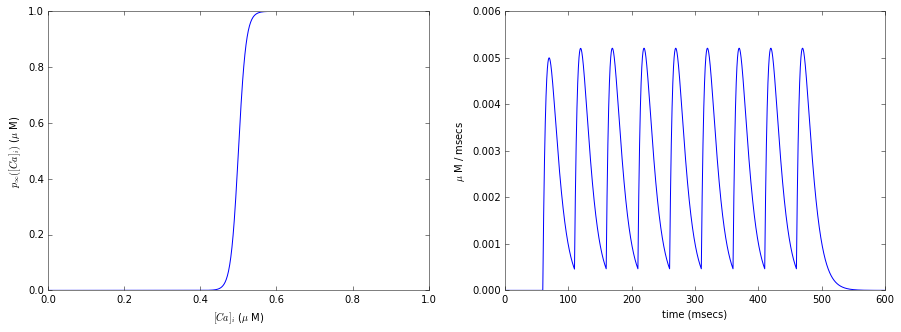

In [16]:
f1=gr.figure(figsize=(15,5))
r=1; c=2; gr.ioff()
ax1=f1.add_subplot(r,c,1)
ax2=f1.add_subplot(r,c,2)
ca=sc.arange(0,1,0.001)
ax1.plot(ca, p["pR_ss"](ca))
ax2.plot(sampTimes, p["phi"](sampTimes))
ax1.set_xlabel("$[Ca]_i$ ($\mu$ M)")
ax1.set_ylabel("$p_{\infty}([Ca]_i)$ ($\mu$ M)")
ax2.set_xlabel("time (msecs)")
ax2.set_ylabel("$\mu$ M / msecs")
gr.ion(); gr.draw()

## System dynamics

In [17]:
def preSynCaSTSP(U,t,par):
    c,pR,q=U
    dc = (par["c_ss"]-c)/par["tau_c"] + par["phi"](t)
    dpR = (par["pR_ss"](c) -pR)/par["tau_pR"]
    dq =  q * (par["q_ss"] - q) /par["tau_q"] - (1-q)*pR
    return sc.array([dc, dpR, dq])

In [18]:
def RK4(f,p):
    return lambda y, t, dt: (
            lambda dy1: (
            lambda dy2: (
            lambda dy3: (
            lambda dy4: (dy1 + 2*dy2 + 2*dy3 + dy4)/6
            )( dt * f( y + dy3, t + dt  , p   ) )
        )( dt * f( y + dy2/2, t + dt/2, p ) )
        )( dt * f( y + dy1/2, t + dt/2, p ) )
        )( dt * f( y, t, p ) )

def solveRK4(p):
    U=sc.zeros((p["nSteps"],p["nDim"]),"float64")
    dU = RK4(p["rhs"],p)
    U[0]=p["ic"]
    for n in sc.arange(1,p["nSteps"]):
        U[n] = U[n-1] + dU( U[n-1], p["sampTimes"][n-1], p["timeStep"])
        if (p["sampTimes"][n]%1000)<0.001:
            print("t=%g, y=%g, w=%g"%(p["sampTimes"][n], U[n][0],U[n][1]))
    return U.transpose()

In [19]:
p["tau_pR"]= 1.0; p["tau_q"]=30.0; p["tau_c"]=10.0; p["tau_syn"]=10.0,
p["g_pR"]= 1.0/100.0; 
p["q_ss"]=0.9; p["c_ss"]= 1e-3; p["stim_Amp"]= 0.05,
p["c_p"]=0.5
p["rhs"]=preSynCaSTSP
p["ic"]= sc.array([0.001, 0.1, 0.6 ])
p["nDim"]=3; p["nSteps"]=len(p["sampTimes"])
#p["timeMax"]=600.0; 
p["timeStep"]=1e-3
p["sampTimes"] = sc.arange(0,p["timeMax"],p["timeStep"])
orbit=solveRK4(p)
#orbit1= odeint(p["rhs"], p["ic"],p["sampTimes"],args=(p,))

In [9]:
print(orbit.shape)
ca=orbit[0]
pR=orbit[1]
q=orbit[2]
pRq= pR*q
print(len(p["sampTimes"]),ca.shape, pR.shape, q.shape, pRq.shape)

(3, 60000)
600000 (60000,) (60000,) (60000,) (60000,)


ValueError: x and y must have same first dimension

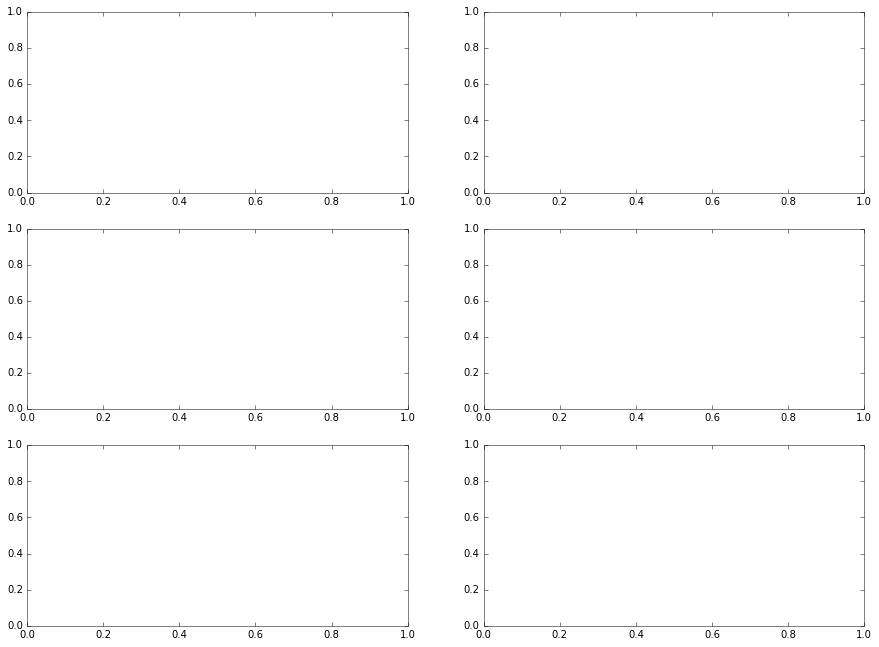

In [10]:
f2=gr.figure(figsize=(15,11))
r=3; c=2; gr.ioff()
ax=list()
labs=[r"$c$", r"$p$", r"$q$"]
for n in sc.arange(r*c):
    ax.append(f2.add_subplot(r,c,n+1))
    
for n in sc.arange(r):    
    ax[c*n].plot(p["sampTimes"],orbit[n],label=labs[n])

ax[2].plot(p["sampTimes"], pRq,label=r"$pq$")
ax[4].plot(p["sampTimes"], pRq,label=r"$pq$")

ax[1].plot(pR, ca, label=r"$(p,c)$")    
ax[3].plot(ca, pR, 'b', label=r"$(c,p)$") 
ax[3].plot(ca, pRq, 'g', label=r"$(c,qp)$") 
ax[5].plot(ca, q, 'b', label=r"$(c,q)$")
ax[5].plot(ca, pRq, 'g', label=r"$(c,qp)$")


for n in sc.arange(r):
    ax[c*n +1].set_xlim(0,1)

for n in sc.arange(r*c):
    ax[n].set_ylim(0,1)
    ax[n].legend()

gr.ion(); gr.draw();